In [7]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statannot import add_stat_annotation
from tqdm import tqdm
import copy
from scipy.stats import linregress
from scipy.optimize import curve_fit
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 10 
from scipy import stats
from numpy import random
import trackpy as tp

# Function Definitions

In [8]:
def compute_char(data_frame,vt):
    #compute: 
    # 1) speed 
    # 2) arrest coefficient i.e. time frames speend below vt
    # 3) mean speed

    for count,part in enumerate(data_frame.particle.unique()):
        df = data_frame.loc[data_frame.particle == part].sort_values(by=['frame']) 
        if len(df) > 3:
            dx = df.x.diff(1)
            dy = df.y.diff(1)
            dt = 3*df.frame.diff(1)
            vx= (dx/dt).to_numpy()
            vy= (dy/dt).to_numpy()
            v = np.sqrt(vx**2 + vy**2)
            real_v = v[1:-1]
            if(len(real_v)):
                a=len(real_v[real_v <= vt])/len(real_v)
            else: # zero length
                a=np.nan
            new_df={'particle':df.particle.iloc[0]*np.ones(len(real_v)),
                    'date':df.date.iloc[0] *np.ones(len(real_v)),
                    'v':real_v,
                    'frame_index':np.arange(0,len(real_v)),
                    'well':df.well.iloc[0] *np.ones(len(real_v)),
                    'arrest': a * np.ones(len(real_v)),'mv':np.mean(real_v) * np.ones(len(real_v)),
                    'x':df.x.iloc[1:-1],
                    'y': df.y.iloc[1:-1],
                    'frame': df.frame.iloc[1:-1],
                    'numf': df.shape[0]}
            if(count == 0):
                out=pandas.DataFrame(new_df)
            else:  
                out=pandas.concat([out,pandas.DataFrame(new_df)])
    return out 

def compute_char_well(data_frame):
    
    #characteristics per well:
    # 1) mean arrest coefficient
    # 2) num of cells
    # 3) mean speed

    for count,well in enumerate(data_frame.well.unique()):
        df = data_frame.loc[data_frame.well == well]
        coll_a = [df[df.particle == p].arrest.iloc[0] for p in df.particle.unique()]
        coll_v = [df[df.particle == p].mv.iloc[0] for p in df.particle.unique()]
        new_df={'well':df.well.iloc[0],'date':df.date.iloc[0],
                'arrest': np.nanmean(coll_a),
                'v': np.nanmean(coll_v),
                'cells': len(df.particle.unique())}
        if(count == 0):
            out=pandas.DataFrame(new_df, index=[0])
        else:  
            out=pandas.concat([out,pandas.DataFrame(new_df, index=[0])])
            
    return out 

def select_well_prop_per_part(data_frame_track):
    for count,part in enumerate(data_frame_track.particle.unique()):
        df = data_frame_track.loc[data_frame_track.particle == part]
        new_df={'well':df.well.iloc[0],'date':df.date.iloc[0],'particle':df.particle.iloc[0],'arrest':df.arrest.iloc[0],
                'mv':df.mv.iloc[0]}
        if(count == 0):
            out=pandas.DataFrame(new_df, index=[0])
        else:  
            out=pandas.concat([out,pandas.DataFrame(new_df, index=[0])])   
    return out

# Load data

In [9]:
data_on_spheroid = pandas.read_csv(r'Data\Trajectories_on_spheroids.csv')
tracks_wt_spheroid = data_on_spheroid.loc[data_on_spheroid.type == 'wt'].reset_index(drop = True)
tracks_apc_spheroid = data_on_spheroid.loc[data_on_spheroid.type == 'apc'].reset_index(drop = True)

In [10]:
data_on_matrigel = pandas.read_csv(r'Data\Trajectories_in_matrigel.csv')
tracks_wt_matrigel = data_on_matrigel.loc[data_on_matrigel.type == 'wt'].reset_index(drop = True)
tracks_apc_matrigel = data_on_matrigel.loc[data_on_matrigel.type == 'apc'].reset_index(drop = True)

In [11]:
vel_thresh = 1

np.seterr(divide='ignore', invalid='ignore')
data_apc_on=compute_char(tracks_apc_spheroid,vel_thresh)
data_wt_on=compute_char(tracks_wt_spheroid,vel_thresh)
np.seterr(divide='warn', invalid='warn')

np.seterr(divide='ignore', invalid='ignore')
data_apc_out=compute_char(tracks_apc_matrigel,vel_thresh)
data_wt_out=compute_char(tracks_wt_matrigel,vel_thresh)
np.seterr(divide='warn', invalid='warn')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

# Single cell trajectory on spheroid

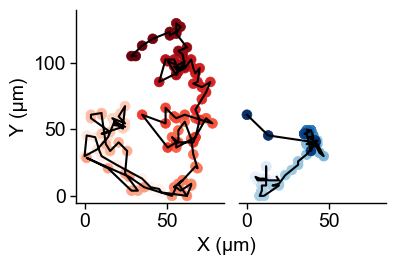

In [12]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1,2, figsize = (4.,2.5))

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.1)

for i in [0,1]:
    ax[i].set_xlim(-5,85)
    ax[i].set_ylim(-5,140)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(True)
    ax[i].spines['left'].set_visible(True)
    ax[i].tick_params(axis='x', labelsize=14, rotation=0)
    ax[i].tick_params(axis='y', labelsize=14)        
    ax[i].tick_params(width=1, length=4)
    for axis in ['bottom','left']:
        ax[i].spines[axis].set_linewidth(1)
ax[0].spines['left'].set_visible(True)
ax[1].spines['left'].set_visible(False)

particle_nb = 35
tracks_wt_no_nan = data_wt_on
time = np.array(tracks_wt_no_nan.loc[tracks_wt_no_nan.particle == particle_nb, 'frame']*3)
time = time - np.min(time)
X = np.array(tracks_wt_no_nan.loc[tracks_wt_no_nan.particle == particle_nb, 'x'])
X = X - np.min(X)
Y = np.array(tracks_wt_no_nan.loc[tracks_wt_no_nan.particle == particle_nb, 'y'])
Y = Y - np.min(Y)
ax[1].scatter(X,Y, c = time, cmap = 'Blues', linewidths = 0.5, s= 50)
ax[1].plot(X,Y, c ='k')
ax[0].set_ylabel('Y (µm)', fontsize=14)
ax[1].set_xlabel(' ', fontsize=14)

particle_nb = 22
tracks_apc_no_nan = data_apc_on.dropna()
time = np.array(tracks_apc_no_nan.loc[tracks_apc_no_nan.particle == particle_nb, 'frame']*3)
time = time - np.min(time)
X = np.array(tracks_apc_no_nan.loc[tracks_apc_no_nan.particle == particle_nb, 'x'])
X = X - np.min(X)
Y = np.array(tracks_apc_no_nan.loc[tracks_apc_no_nan.particle == particle_nb, 'y'])
Y = Y - np.min(Y)
ax[0].plot(X,Y, c ='k')
ax[0].scatter(X,Y, c = time, cmap = 'Reds', linewidths = 0.5, s = 50)
ax[1].set_ylabel(' ', fontsize=14)
ax[0].set_xlabel(' ', fontsize=14)

labels = []
ax[1].set_yticklabels(labels, fontsize = 12)
ax[1].set_yticks([])
fig.supxlabel('X (µm)', fontsize = 14, ha = 'center', y = -0.1)
plt.show()

# Single cell MSD on spheroids

In [13]:
im_wt_on = tp.imsd(tracks_wt_spheroid, 1, 1/3)
im_apc_on = tp.imsd(tracks_apc_spheroid, 1, 1/3)

max_ = 8

msd_wt_on_spheroid = []
for i in [q for q in range(len(im_wt_on.columns))]:
    slope, intercept, r_value, p_value, std_err = linregress(np.log10(np.array(im_wt_on.index))[0:max_], np.log10(np.array(im_wt_on[im_wt_on.columns[i]]))[0:max_])
    msd_wt_on_spheroid.append([im_wt_on.columns[i], slope, intercept, r_value**2, p_value, std_err])
    
msd_apc_on_spheroid = []
for i in [q for q in range(len(im_apc_on.columns))]:
    slope, intercept, r_value, p_value, std_err = linregress(np.log10(np.array(im_apc_on.index))[0:max_], np.log10(np.array(im_apc_on[im_apc_on.columns[i]]))[0:max_])
    msd_apc_on_spheroid.append([im_apc_on.columns[i], slope, intercept, r_value**2, p_value, std_err])
    
msd_wt_on_part = pandas.DataFrame(msd_wt_on_spheroid, columns = ['particle', 'alpha', 'intercept', 'R2', 'p_val', 'std_err'])
msd_wt_on_part['type'] = 'wt'

msd_apc_on_part = pandas.DataFrame(msd_apc_on_spheroid, columns = ['particle', 'alpha', 'intercept', 'R2', 'p_val', 'std_err'])
msd_apc_on_part['type'] = 'apc'

msd_part = pandas.concat([msd_wt_on_part,msd_apc_on_part])

C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\numpy\lib\function_base.py:2536: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Passing `palette` without assigning `hue` is deprecated.


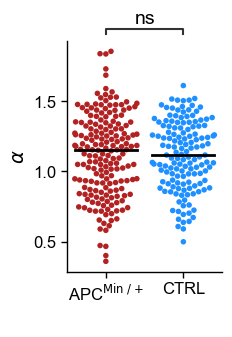

In [14]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, figsize = (2,3))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)       
ax.tick_params(width=1, length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)

order = ['apc', 'wt']
    
ax = sns.swarmplot(data=msd_part.loc[msd_part.R2 > 0.8],
                   y='alpha',
                   x = 'type',
                   order = order,
                   size=4,
                   palette = ['firebrick', 'dodgerblue'],
                   dodge = False)

sns.boxplot(medianprops={'visible': True, 'color': 'k', 'ls': '-', 'lw': 2},
            whiskerprops={'visible': False},
            zorder=10,
            y="alpha",
            x = 'type',
            order = order,
            data=msd_part.loc[msd_part.R2 > 0.8],
            showfliers=False,
            showbox=False,
            showcaps=False,)

add_stat_annotation(ax,
                    data=msd_part.loc[msd_part.R2 > 0.8],
                    y='alpha',
                    x = 'type',
                    order = order,
                    box_pairs=[('wt','apc')],
                    test='Mann-Whitney', comparisons_correction=None, 
                    fontsize = 14,
                    text_format='star', loc='outside', verbose=0)

ax.set_ylabel(r'$\alpha$', fontsize=14)
ax.set_xlabel(' ', fontsize=14)
labels = [r'APC$^{\mathrm{Min}\ /+}$', 'CTRL']
ax.set_xticklabels(labels, fontsize=12)
plt.show()

# Pause time distributions

In [15]:
threshold = 1
data_wt_on['thresh_vel'] = (np.array(data_wt_on['v']) > threshold)*1
data_apc_on['thresh_vel'] = (np.array(data_apc_on['v']) > threshold)*1

from itertools import groupby
def groups(l, val):
    return [len(list(g)) for i, g in groupby(l) if i == val]

distrib_pause_wt = []
for part in data_wt_on.particle.unique():
    L = np.array(data_wt_on.loc[data_wt_on.particle == part, 'thresh_vel'])
    distrib_pause_wt.append([groups(L, 0)])
    
distrib_pause_apc = []
for part in data_apc_on.particle.unique():
    L = np.array(data_apc_on.loc[data_apc_on.particle == part, 'thresh_vel'])
    distrib_pause_apc.append([groups(L, 0)])
    
    avg_pause_wt = []
for k in range(len(distrib_pause_wt)):
    avg_pause_wt.append(np.mean(distrib_pause_wt[k]))
    
avg_pause_apc = []
for k in range(len(distrib_pause_apc)):
    avg_pause_apc.append(np.mean(distrib_pause_apc[k]))
    
# Convert in minutes
avg_pause_wt = np.array(avg_pause_wt)*3
avg_pause_apc = np.array(avg_pause_apc)*3

C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\vabonnet\AppData\Local\miniconda3\envs\APC\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


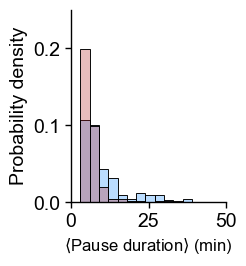

In [16]:
# Define font
plt.rc('font',family='Arial')

# Plot
fig, ax = plt.subplots(1, figsize = (2,2.5))
ax.set_xlim(0,50)
ax.set_ylim(0,0.25)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.tick_params(axis='x', labelsize=14, rotation=0)
ax.tick_params(axis='y', labelsize=14)        
ax.tick_params(width=1, length=4)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)
ax.spines['left'].set_visible(True)

b = 3
sns.histplot(ax = ax, data = avg_pause_wt, stat = 'density', binwidth = b, color = 'dodgerblue', alpha = 0.3, cumulative=False, label = r'$CTRL^{ }$')
sns.histplot(ax = ax, data = avg_pause_apc, stat = 'density', binwidth = b, color = 'firebrick', alpha = 0.3, cumulative=False, label = r'$APC^{Min\ /+}$')

ax.set_xlabel(r'$\langle$Pause duration$\rangle$ (min)', fontsize = 12)
ax.set_ylabel('Probability density', fontsize = 14)
plt.show()